# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [92]:
import keras
from keras import activations
from keras import utils
import warnings

warnings.filterwarnings('ignore')

from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """

        ###############
        ### Step №1 ###
        ###############

        X = self.scaler.fit_transform(X)

        if self.use_PCA == True:
        
            self.pca = PCA(n_components=self.new_dim, whiten=True)
            X = self.pca.fit_transform(X)

        ###############
        ### Step №2 ###
        ###############

        subsample_size = 1000000
        i = np.random.randint(X.shape[0], size=subsample_size)
        j = np.random.randint(X.shape[0], size=subsample_size)
        # j = np.random.choice(np.setdiff1d(np.arange(X.shape[0]), i), subsample_size)

        sigma = np.median(np.sum((X[i, :] - X[j, :])**2, axis=1))

        ###############
        ### Step №3 ###
        ###############

        self.w = np.random.normal(0, 1/np.sqrt(sigma), (X.shape[1], self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        ###############
        ### Step №4 ###
        ###############

        self.new_x = np.cos(X @ self.w + self.b)

        ###############
        ### Step №5 ###
        ###############

        if self.classifier == 'logreg':

            self.model = LogisticRegression()
            self.model.fit(self.new_x, y)

        elif self.classifier == 'SVM':

            self.model = SVC(kernel='linear',probability=True)
            self.model.fit(self.new_x, y)

        elif self.classifier == 'linreg':

            self.model = LinearRegression()
            self.model.fit(self.new_x, y)
        

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """

        if self.use_PCA == True:

            X = self.pca.transform(X)
                
        new_x_test = np.cos(X @ self.w + self.b)

        return self.model.predict_proba(new_x_test)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """

        X = self.scaler.transform(X)

        if self.use_PCA == True:

            X = self.pca.transform(X)
                
        new_x_test = np.cos(X @ self.w + self.b)

        return self.model.predict(new_x_test)
    

# ind = np.random.randint(0, x_train.shape[0], 10000)
# x_tr, y_tr = x_train[ind, :], y_train[ind]

rffp = RFFPipeline(classifier='logreg')
rffp.fit(x_train, y_train)
print(f'Accuracy using LogisticRegression: {accuracy_score(y_test, rffp.predict(x_test))}')

Accuracy using SVM: 0.8578


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

## Сравнение _**Linear SVM**_ и _**Kernel SVM**_

In [94]:
import time

ind = np.random.randint(0, x_train.shape[0], 10000)
x_tr, y_tr = x_train[ind, :], y_train[ind]


svm_1 = SVC(kernel='linear')
svm_2 = RFFPipeline(classifier='SVM')

time_start = time.time()
svm_1.fit(x_tr, y_tr)
print(f'Time spent on fitting (Linear SVM): {time.time() - time_start} sec')

time_start = time.time()
svm_1.predict(x_test)
print(f'Time spent on predicting (Linear SVM): {time.time() - time_start} sec')
print(f'Accuracy using Linear SVM: {accuracy_score(y_test, svm_1.predict(x_test))}', '\n')

time_start = time.time()
svm_2.fit(x_tr, y_tr)
print(f'Time spent on fitting (Kernel SVM): {time.time() - time_start} sec')

time_start = time.time()
svm_2.predict(x_test)
print(f'Time spent on predicting (Kernel SVM): {time.time() - time_start} sec')
print(f'Accuracy using Kernel SVM: {accuracy_score(y_test, svm_2.predict(x_test))}')

Time spent on fitting (Linear SVM): 10.170814990997314 sec
Time spent on predicting (Linear SVM): 12.779335975646973 sec
Accuracy using Linear SVM: 0.7934 

Time spent on fitting (Kernel SVM): 62.42820906639099 sec
Time spent on predicting (Kernel SVM): 17.17910599708557 sec
Accuracy using Kernel SVM: 0.8257


## Применение _**CatBoost**_

In [95]:
import catboost

ind_tr = np.random.choice(np.arange(x_train.shape[0]), size=int(x_train.shape[0] * 0.7), replace=False)
ind_val = np.setdiff1d(np.arange(x_train.shape[0]), ind_tr)

pca = PCA(n_components=50, whiten=True)

X_tr, X_val = x_train[ind_tr, :], x_train[ind_val, :]
Y_tr, Y_val = y_train[ind_tr], y_train[ind_val]

X_tr = pca.fit_transform(X_tr)
X_val = pca.transform(X_val)

best_acc = 0
best_iter = None
best_lr = None

for it in [100, 200, 300]:
    for lr in [0.1, 0.1, 0.5]:

        cb = catboost.CatBoostClassifier(iterations=it, learning_rate=lr, verbose=False)
        cb.fit(X_tr, Y_tr)

        acc = accuracy_score(Y_val, cb.predict(X_val))

        if acc > best_acc:

            best_acc = acc
            best_iter = it
            best_lr = lr

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

#####################
### Learning time ###
#####################

cb = catboost.CatBoostClassifier(iterations=best_iter, learning_rate=best_lr, verbose=False)

time_start = time.time()

cb.fit(x_train_pca, y_train)

print(f'Time spent on learning: {time.time() - time_start} sec')

#######################
### Prediction time ###
#######################

time_start = time.time()

pred = cb.predict(x_test_pca)

print(f'Time spent on predicting: {time.time() - time_start} sec')

print(f'Accuracy using CatBoost: {accuracy_score(y_test, pred)}')

Time spent on learning: 10.759475946426392 sec
Time spent on predicting: 0.10596489906311035 sec
Accuracy using CatBoost: 0.8629


> ## <div style='color:red'> Вывод: </div>
>
> #### Сравнивая CatBoost с ядровым LogisticRegression и SVM, следует выбирать модель градиентного бустинга, потому что:
>
> * #### **Время предсказания:** если бы речь шла о выпуске модель в продакшн, то использование модели градиентного бустинга было бы более предпочтительным, поскольку 0.1 секунда на предсказание против 12 секунд (лучший результат у ядрового LogisticRegression) является значительным отрывом
>
> * #### **Качество:** что ядровый LogisticRegression, что SVM не могут обогнать по качеству CatBoost, но стоит отметить, что качество ядровых моделей не сильно хуже, чем модель градиентного бустинга
>
> * #### **Время обучения:** тут CatBoost не сильно обгоняет LogisticRegression во времени обучения, вопрос в качестве 

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

## _**Пункт 3.1**_

In [96]:
#########################
### LogReg comparison ###
#########################

rffp_pca = RFFPipeline(use_PCA=True, classifier='logreg')
rffp_not_pca = RFFPipeline(use_PCA=False, classifier='logreg')

rffp_pca.fit(x_tr, y_tr)
rffp_not_pca.fit(x_tr, y_tr)

print(f'Logistic Regression')
print(f'With PCA: {accuracy_score(y_test, rffp_pca.predict(x_test))}')
print(f'Without PCA: {accuracy_score(y_test, rffp_not_pca.predict(x_test))}', '\n')

######################
### SVM comparison ###
######################

rffp_pca = RFFPipeline(use_PCA=True, classifier='SVM')
rffp_not_pca = RFFPipeline(use_PCA=False, classifier='SVM')

rffp_pca.fit(x_tr, y_tr)
rffp_not_pca.fit(x_tr, y_tr)

print(f'SVM')
print(f'With PCA: {accuracy_score(y_test, rffp_pca.predict(x_test))}')
print(f'Without PCA: {accuracy_score(y_test, rffp_not_pca.predict(x_test))}', '\n')

Logistic Regression
With PCA: 0.8347
Without PCA: 0.8332 

SVM
With PCA: 0.8264
Without PCA: 0.8272 



> ## <div style='color:red'> Вывод: </div>
>
> #### Эксперимент показал, что использование PCA не сильно влияет на качество. Однако стоит сказать, что на такой результат повлияло использование StandartScaler: ядровые модели без использования StandartScaler и PCA показали значение $Accuracy$ в районе $ \approx $ 0.1

## _**Пункт 3.2**_

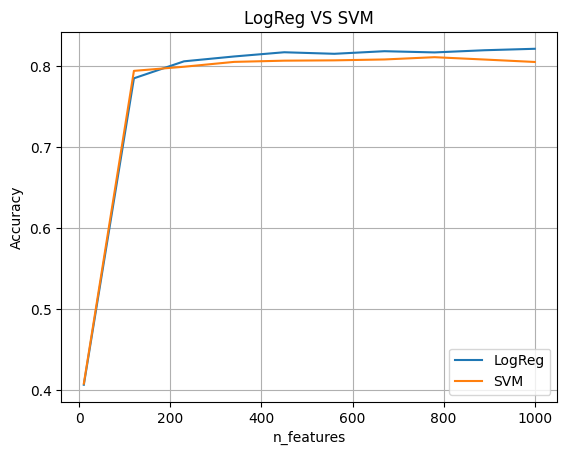

In [97]:
import matplotlib.pyplot as plt

n = np.linspace(10, 1000, 10, dtype='int64')

accs_lr = []
accs_svm = []

indx = np.random.choice(np.arange(x_train.shape[0]), size=5000, replace=False)

x_tr = x_train[indx, :]
y_tr = y_train[indx]

for n_feats in n:

    rffp_lr = RFFPipeline(n_features=n_feats, classifier='logreg')
    rffp_svm = RFFPipeline(n_features=n_feats, classifier='SVM')

    rffp_lr.fit(x_tr, y_tr)
    rffp_svm.fit(x_tr, y_tr)

    accs_lr.append(accuracy_score(y_test, rffp_lr.predict(x_test)))
    accs_svm.append(accuracy_score(y_test, rffp_svm.predict(x_test)))

plt.title('LogReg VS SVM')
plt.grid()
plt.xlabel('n_features')
plt.ylabel('Accuracy')
plt.plot(n, accs_lr, label='LogReg')
plt.plot(n, accs_svm, label='SVM')
plt.legend();

> ## <div style='color:red'> Вывод: </div>
>
> #### С ростом числа генерируемых фичей значение $ Accuracy $ стремительно растет, однако после определенного количества фичей значение $ Accuracy $ перестает расти как для SVM, так и для LogisticRegression

## _**Пункт 3.3**_

In [98]:
fit_time_lr = []
fit_time_svm = []

predict_time_lr = []
predict_time_svm = []

for n_feats in n:

    rffp_lr = RFFPipeline(n_features=n_feats, classifier='logreg')
    rffp_svm = RFFPipeline(n_features=n_feats, classifier='SVM')

    #######################
    ### Fit time LogReg ###
    #######################

    lr_start = time.time()
    rffp_lr.fit(x_tr, y_tr)
    fit_time_lr.append(time.time() - lr_start)

    ####################
    ### Fit time SVM ###
    ####################

    svm_start = time.time()
    rffp_svm.fit(x_tr, y_tr)
    fit_time_svm.append(time.time() - svm_start)


    ##############################
    ### Prediction time LogReg ###
    ##############################

    lr_start = time.time()
    rffp_lr.predict(x_test)
    predict_time_lr.append(time.time() - lr_start)

    ###########################
    ### Prediction time SVM ###
    ###########################

    svm_start = time.time()
    rffp_svm.predict(x_test)
    predict_time_svm.append(time.time() - svm_start)


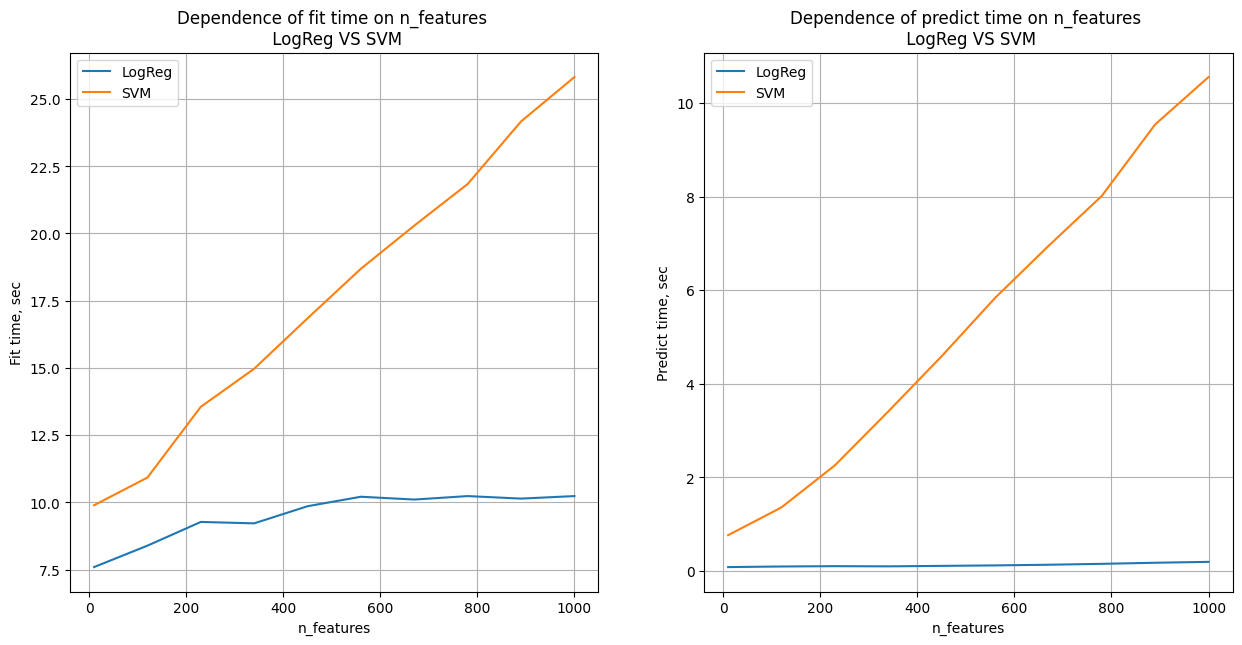

In [99]:
f, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].grid()
ax[0].set_title('Dependence of fit time on n_features \n LogReg VS SVM')
ax[0].plot(n,fit_time_lr, label='LogReg')
ax[0].plot(n,fit_time_svm, label='SVM')
ax[0].set_ylabel('Fit time, sec')
ax[0].set_xlabel('n_features')
ax[0].legend()

ax[1].grid()
ax[1].set_title('Dependence of predict time on n_features \n LogReg VS SVM')
ax[1].plot(n,predict_time_lr, label='LogReg')
ax[1].plot(n,predict_time_svm, label='SVM')
ax[1].set_ylabel('Predict time, sec')
ax[1].set_xlabel('n_features')
ax[1].legend();

> ## <div style='color:red'> Вывод: </div>
>
> #### Важно ли, какую модель обучать — логистическую регрессию или SVM? Да
> 
> #### В случае SVM с ростом генерируемых фичей время обучения стремительно растет, как и время предсказания. Для LogisticRegression время обучения находится примерно на одном и том же значении для произвольного количества генерируемых фичей. Что касается прогнозов, LogisticRegression требуется значительно меньше времени, для произвольного набора фичей прогноз занимает примерно 0 секунд. Также графики времени обучения / предсказания  SVM и LogisticRegression и график зависимости $ Accuracy $ от количества фичей показали, что лучше использовать LogisticRegression из-за времени обучения, времени предсказания и качества 

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

> ### <div style='color:red'> Алгоритм для ORFFeatures </div>
>
> #### Введем обозначения: $d$ - размерность входной матрицы признаков, $D$ - размерность выходной (новой) матрицы признаков. Вначале происходит расчет параметра $\sigma$, как это было в 1-м задании. После чего генерируется новая матрица признаков следующим образом:
> ### $$ W_{ORF} = \frac{1}{\sigma} SQ, \ W_{ORF} \isin \mathbf{R}^{d \times d} $$
> #### где $S$ - диагональная матрица, на диагонали которой находятся элементы из $\chi$-распределения с $d$ степенями свободы. Матрица $Q$ - ортогональная матрица, полученная из QR разложения гауссовой матрицы (матрица, у который каждый элемент распределен стандартно нормально и независим от других элементов)
>
> ### **Случай для $D \leq d$**
>
> #### В случай, когда размерность новой матрицы меньше, чем размерность входной матрицы, тогда используются первые $D$ строк из сгенерированной матрицы $W_{ORF}$
>
> ### **Случай для $D > d$**
>
> #### В статье предполагается, что выбирается $D$ кратное $d$. Поэтому в случае, когда размерность новой матрицы больше, чем размерность входной матрицы, генерируется $\frac{D}{d}$ матриц $W_{ORF}^i \isin \mathbf{R}^{d \times d}$ и конкатинируются в одну большую матрицу $W_{ORF} \isin \mathbf{R}^{D \times d}$
>
> ### **Обучение и предсказание**
>
> #### После того как была получена матрица $W_{ORF} \isin \mathbf{R}^{D \times d}$ преобразовываем $X\_train$ по аналогии с RFF:
>
> ### $$ X\_train_{NEW} = cos(X\_train \times W_{ORF}^T + b) $$
>
> #### где $b \sim \mathbf{U}(-\pi, \pi)$, $b \isin \mathbf{R}^D$. На этом датасете обучаем подходящую под задачу модель. Аналогично преобразовывем $X\_test$:
>
> ### $$ X\_test_{NEW} = cos(X\_test \times W_{ORF}^T + b) $$
>
> #### и строим предсказания для $X\_test$


In [100]:
class ORFPipline:

    def __init__(self, n_features=20, classifier='linreg'):

        self.D = n_features
        self.classifier = {'linreg': LinearRegression(),
                           'logreg': LogisticRegression()
                           }[classifier]
        

    def generate_matrix(self, sigma, d):

        ##################
        ### D < d case ###
        ##################

        if self.D <= d:


            S = np.diag(np.sqrt(np.random.chisquare(d, d)))
            Q, _ = np.linalg.qr(np.random.normal(0, 1, (d, d)))

            self.W = (S @ Q * 1/sigma)[0:self.D, :]

            return self

        ##################
        ### d < D case ###
        ##################

        elif self.D > d:
            
            times = self.D//d

            for i in range(times):

                S = np.diag(np.sqrt(np.random.chisquare(d, d)))
                Q, _ = np.linalg.qr(np.random.normal(0, 1, (d, d)))

                w = S @ Q * 1/sigma

                if self.W is None:

                    self.W = w
                
                else:

                    self.W = np.vstack((self.W, w))


    def fit(self, X, y):

        ###################
        ### Count Sigma ###
        ###################

        subsample_size = 1000000
        i = np.random.randint(X.shape[0], size=subsample_size)
        j = np.random.randint(X.shape[0], size=subsample_size)

        sigma = np.median(np.sum((X[i, :] - X[j, :])**2, axis=1))

        d = X.shape[1]
        self.W = None
        self.b = np.random.uniform(-np.pi, np.pi, self.D)

        self.generate_matrix(sigma, d)

        new_X = np.cos(X @ self.W.T + self.b)

        self.classifier.fit(new_X, y)

    def predict(self, X):

        X_test = np.cos(X @ self.W.T + self.b)

        return self.classifier.predict(X_test)
        

rffp = RFFPipeline(n_features=x_tr.shape[1]*3, use_PCA=False, classifier='logreg')
orpf = ORFPipline(n_features=x_tr.shape[1]*3, classifier='logreg')

rffp.fit(x_tr, y_tr)
orpf.fit(x_tr, y_tr)

print(f'Accuracy using RFFP: {accuracy_score(y_test, rffp.predict(x_test))}')
print(f'Accuracy using ORFP: {accuracy_score(y_test, orpf.predict(x_test))}')

Accuracy using RFFP: 0.8259
Accuracy using ORFP: 0.7748


> #### На датафрейме MNIST <code>RFF</code> показал себя лучше. Теперь попробуем сравнить <code>RFF</code> и <code>ORF</code> на синтетическом наборе данных. Сгенерируем датасет, в котором будут присутствовать сильно коррелирующие признаки для задачи регрессии. Построим графики зависимостей $MSE$ от степени коррелированности между признаками. Также для каждого эксперимента будем фиксировать количество генерируемых фичей. Итого у нас будут графики зависимости $MSE$ от степени коррелированности признаков при фиксированном количестве генерируемых фичей. Будем предполагать, что в данных присутсвует шум и не все признаки влияют на формирование целевой переменной ($\sim$ 75% влияют)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression

rff = []
orf = []

corr = np.linspace(2, 100, 20).astype('int')

for i in corr:

    X, y = make_regression(n_samples=1000, n_features=40, noise=20, random_state=42, bias=0, n_informative=40, effective_rank=i)

    X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, y, test_size=0.3)

    rffp = RFFPipeline(n_features=X_tr.shape[1]*20, use_PCA=False, classifier='linreg')
    orpf = ORFPipline(n_features=X_tr.shape[1]*20, classifier='linreg')

    rffp.fit(X_tr, Y_tr)
    orpf.fit(X_tr, Y_tr)

    rff.append(mean_squared_error(Y_tst, rffp.predict(X_tst)))
    orf.append(mean_squared_error(Y_tst, orpf.predict(X_tst)))


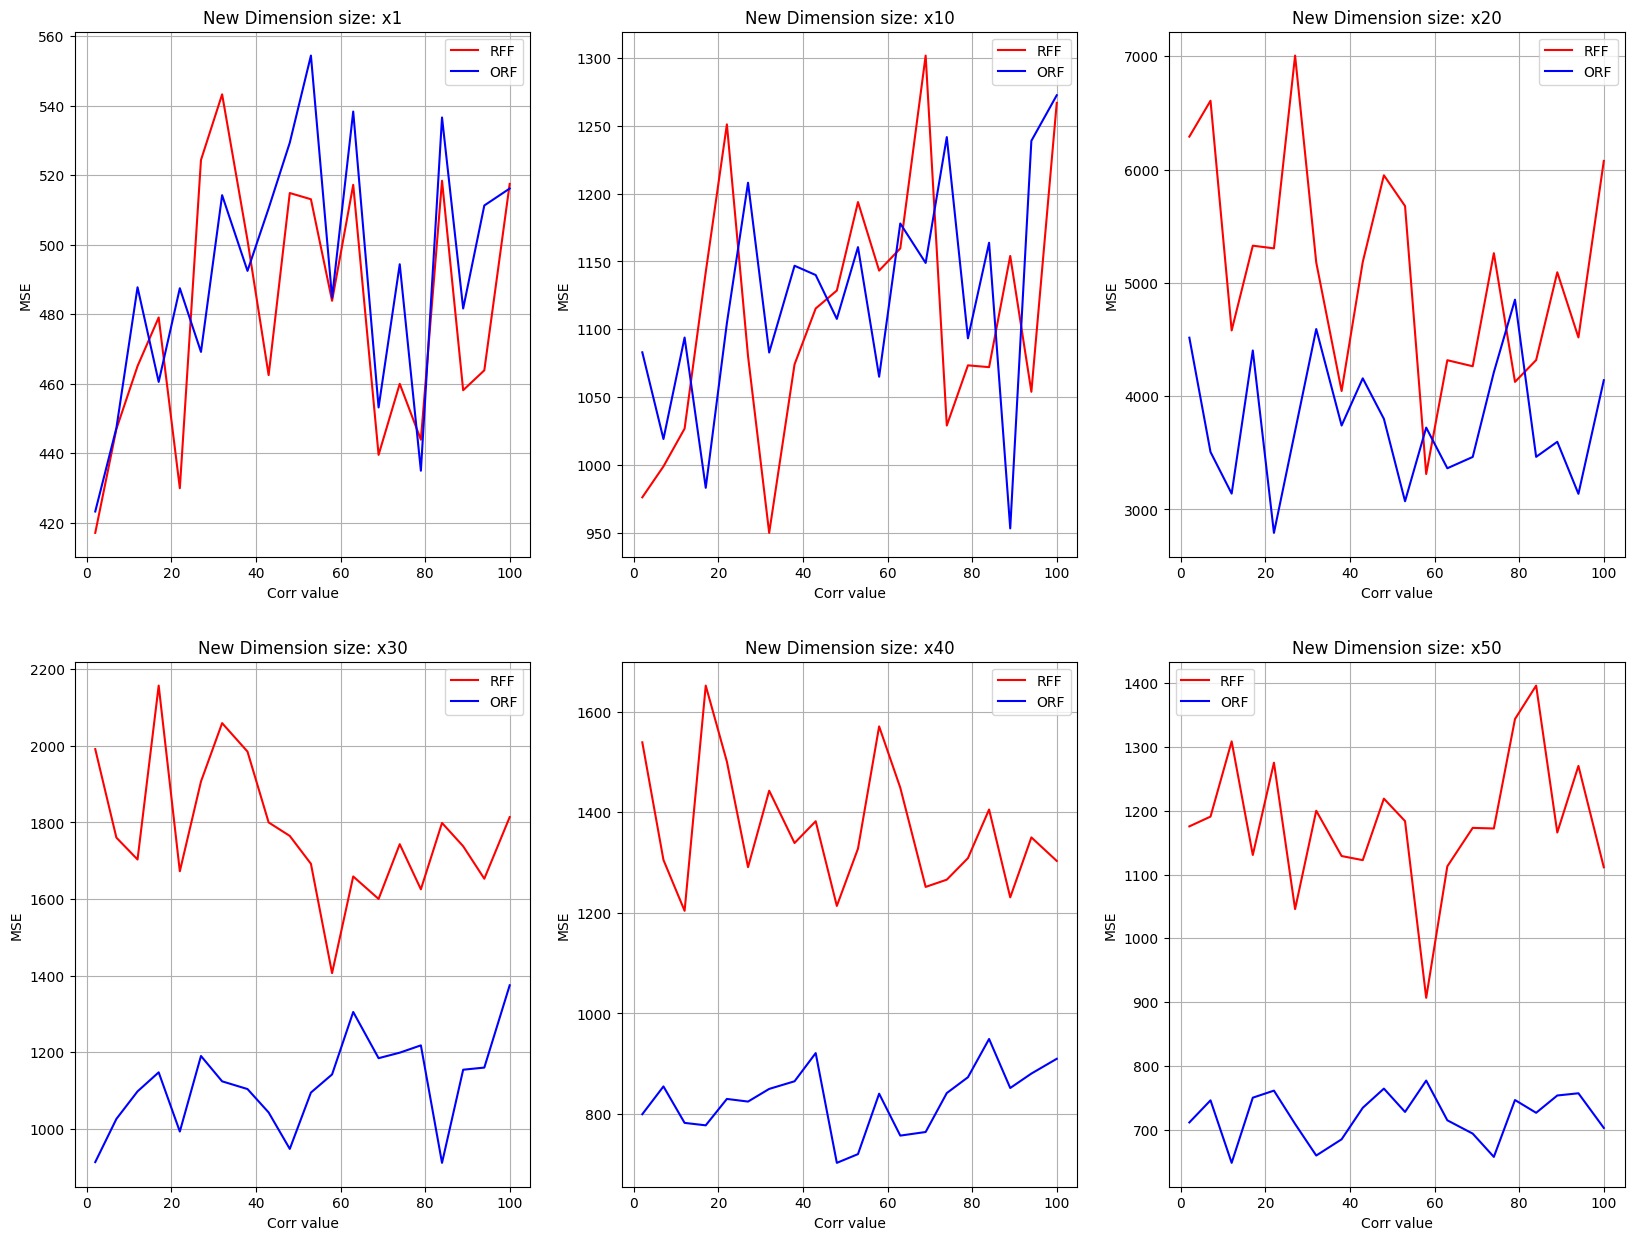

In [102]:
new_dims = np.linspace(1, 50, 6).astype('int')
corr = np.linspace(2, 100, 20).astype('int')

f, ax = plt.subplots(2,3,figsize=(20, 15))

for i, dim in enumerate(new_dims):
    
    rff = []
    orf = []

    ax[i//3][i%3].grid()
    ax[i//3][i%3].set_title(f'New Dimension size: x{dim}')
    ax[i//3][i%3].set_ylabel('MSE')
    ax[i//3][i%3].set_xlabel('Corr value')

    for c in corr:

        X, y = make_regression(n_samples=1000, n_features=40, noise=20, random_state=42, bias=0, n_informative=30, effective_rank=c)

        X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, y, test_size=0.3)

        rffp = RFFPipeline(n_features=X_tr.shape[1]*dim, use_PCA=False, classifier='linreg')
        orpf = ORFPipline(n_features=X_tr.shape[1]*dim, classifier='linreg')

        rffp.fit(X_tr, Y_tr)
        orpf.fit(X_tr, Y_tr)

        rff.append(mean_squared_error(Y_tst, rffp.predict(X_tst)))
        orf.append(mean_squared_error(Y_tst, orpf.predict(X_tst)))

    ax[i//3][i%3].plot(corr, rff, color='red', label='RFF')
    ax[i//3][i%3].plot(corr, orf, color='blue', label='ORF')
    ax[i//3][i%3].legend();

> #### Для задачи регрессии получилось следующее: в среднем <code>ORF</code> показал себя лучше, чем <code>RFF</code>. Он проявил себя лучше в случаях, когда генерируется небольшое количество новых признаков (тут стоит прояснить, что New Dimension size это означает, что генерируется New Dimension size $\times$ X_train.shape[1]). Также степень взаимосвязи влияет на качество модели, однако при огромном количестве генерируемых признаков корреляция между признаками не играет роли и <code>ORF</code> выигрывает с большим отрывом
>
> #### Сравним теперь <code>ORF</code> и <code>RFF</code> в задаче бинарной классификации. Зафиксируем долю объектов с рандомным таргетом равную 0.3. Теперь построим графики зависимости $Accuracy$ от числа коррелированных признаков

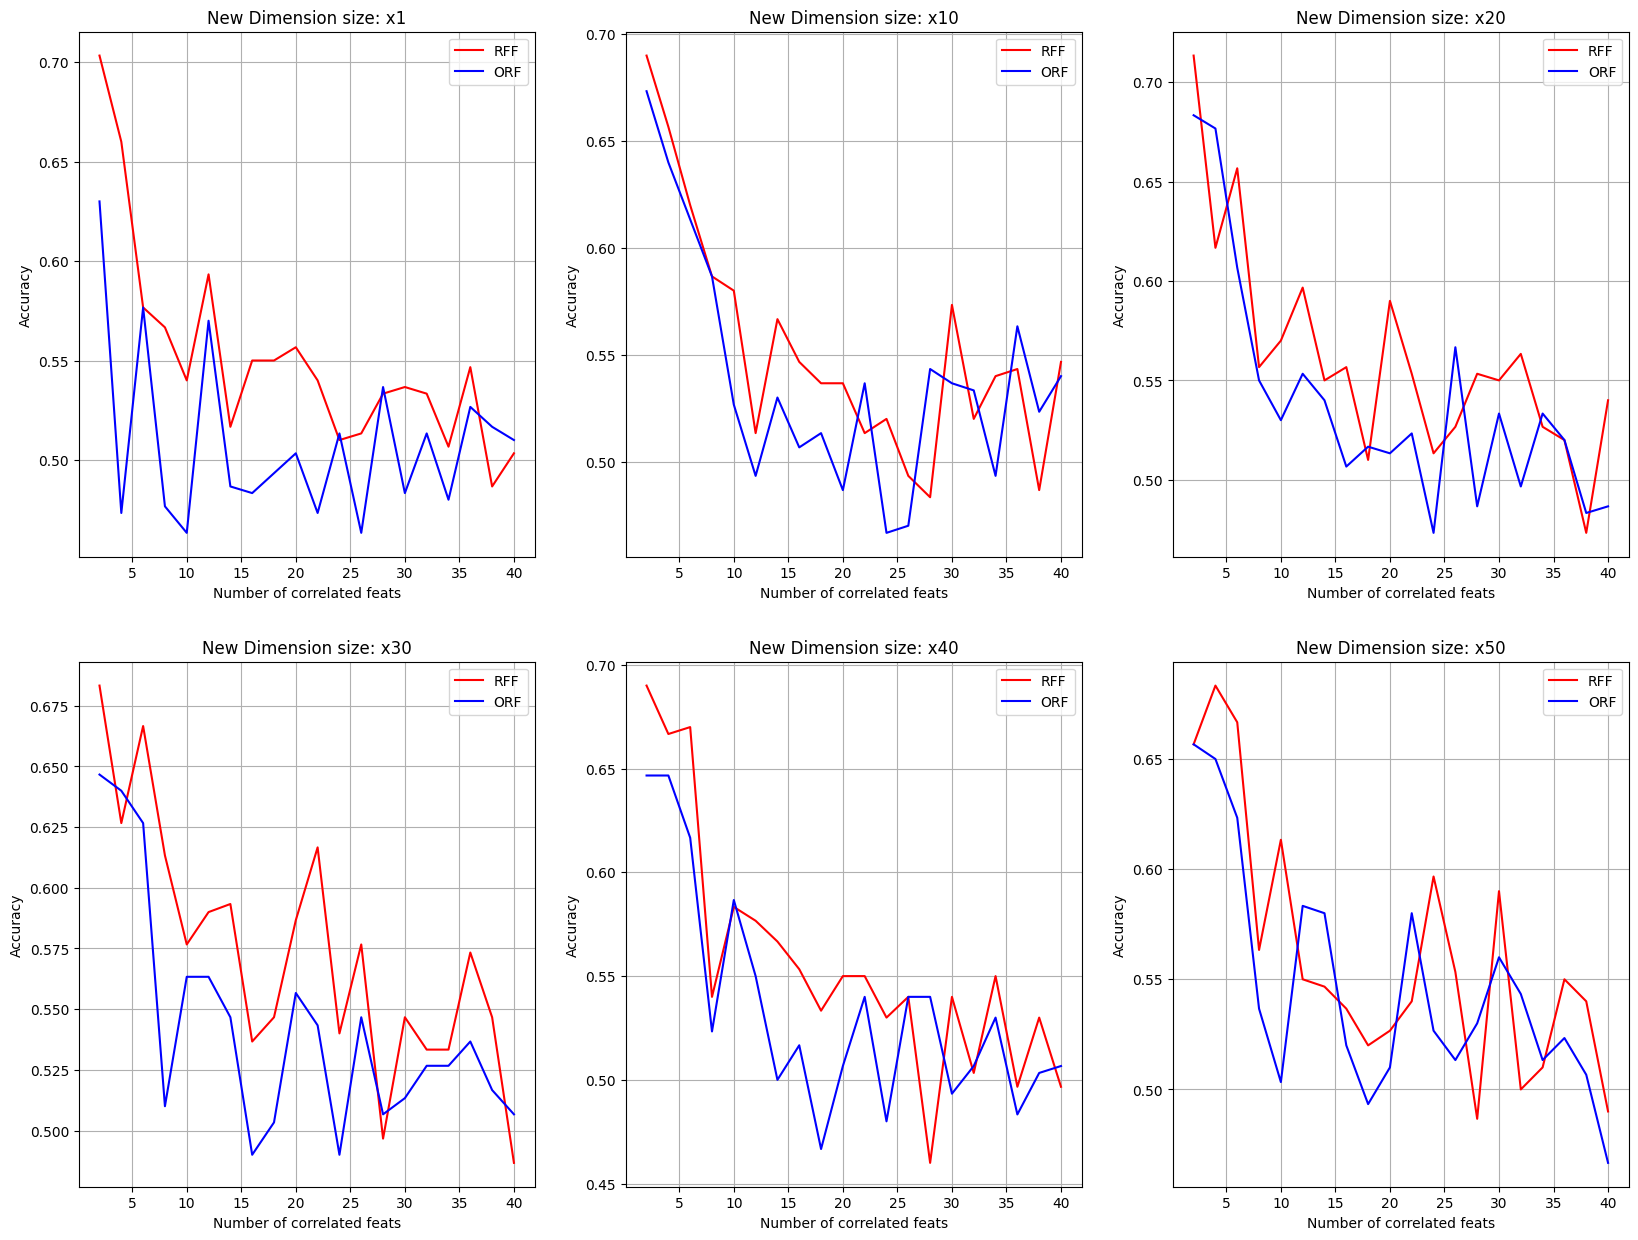

In [103]:
from sklearn.datasets import make_classification

new_dims = np.linspace(1, 50, 6).astype('int')
corr = np.linspace(2, 40, 20).astype('int')

f, ax = plt.subplots(2,3,figsize=(20, 15))

for i, dim in enumerate(new_dims):
    
    rff = []
    orf = []

    ax[i//3][i%3].grid()
    ax[i//3][i%3].set_title(f'New Dimension size: x{dim}')
    ax[i//3][i%3].set_ylabel('Accuracy')
    ax[i//3][i%3].set_xlabel('Number of correlated feats')

    for c in corr:

        X, y = make_classification(n_samples=1000, n_features=40, random_state=42, n_informative=30, n_clusters_per_class=c, flip_y=0.3)

        X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, y, test_size=0.3)

        rffp = RFFPipeline(n_features=X_tr.shape[1]*dim, use_PCA=False, classifier='logreg')
        orpf = ORFPipline(n_features=X_tr.shape[1]*dim, classifier='logreg')

        rffp.fit(X_tr, Y_tr)
        orpf.fit(X_tr, Y_tr)

        rff.append(accuracy_score(Y_tst, rffp.predict(X_tst)))
        orf.append(accuracy_score(Y_tst, orpf.predict(X_tst)))

    ax[i//3][i%3].plot(corr, rff, color='red', label='RFF')
    ax[i//3][i%3].plot(corr, orf, color='blue', label='ORF')
    ax[i//3][i%3].legend();

> ### <div style='color:red'> Вывод </code>
>
> #### Использование <code>ORF</code> оказалось достаточно полезным в задаче регрессии в сравнении с <code>RFF</code>. Очень приятным фактом является, что качество модели зависит от количества генерируемых признаков, генерировать которые не занимает длительное время
>
> #### В задаче бинарной классификации <code>ORF</code> уже не так хорош. Практически во всех случаях <code>RFF</code> показывал больший $Accuracy$, чем <code>ORF</code>. Однако стоит отметить, что в большом количестве экстримальных случаев (случаи, когда почти все признаки скоррелированы, к тому же не стоит забывать, что у 30% объектов тагрет проставлен рандомно) <code>ORF</code> проявил себя лучше, чем <code>RFF</code>. В качестве идеи можно рассмотреть перебор параметра $n\_features$ (кол-во новых признаков)


__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

#### Рассмотрим иные функции для вычисления новых признаков

$$
\tilde \varphi(x) = (\cos (w_1^T x + b_1), \dots, \cos (w_n^T x + b_n)) \quad(0) \\
$$


$$
\tilde \varphi(x) = (sign(w_1^T x + b_1), \dots, sign(w_n^T x + b_n)) \quad(1) \\
$$

$$
\tilde \varphi(x) = ((w_1^T x + b_1)^2, \dots, (w_n^T x + b_n)^2) \quad(2) \\
$$

$$
\tilde \varphi(x) = (\ln(|w_1^T x + b_1| + 1), \dots, \ln(|w_n^T x + b_n| + 1)) \quad(3) \\
$$


$$
\tilde \varphi(x) = (\exp(w_1^T x + b_1), \dots, \exp(w_n^T x + b_n)) \quad(4) \\
$$

$$
\tilde \varphi(x) = (\sin (w_1^T x + b_1), \dots, \sin (w_n^T x + b_n)) \quad(5) \\
$$

#### Видоизменим класс из _**№1**_ добавив возможность выбрать функцию $\varphi(x)$






In [104]:
from sklearn.ensemble import RandomForestClassifier

class RFFPipeline_v2(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=1):

        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        

        funcs = {0: lambda x: np.sin(x),
                 1: lambda x: np.sign(x),
                 2: lambda x: x**2,
                 3: lambda x: np.log(abs(x) + 1),
                 4: lambda x: np.exp(x),
                 5: lambda x: np.sin(x)
                 }
        
        self.func = funcs[func]

        
    def fit(self, X, y):

        if self.use_PCA == True:
        
            self.pca = PCA(n_components=self.new_dim, whiten=True)
            X = self.pca.fit_transform(X)

        subsample_size = 10000
        i = np.random.randint(X.shape[0], size=subsample_size)
        j = np.random.randint(X.shape[0], size=subsample_size)

        sigma = np.median(np.sum((X[i, :] - X[j, :])**2, axis=1))

        self.w = np.random.normal(0, 1/sigma, (X.shape[1], self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        #######################
        ### Choose function ###
        #######################

        new_x = self.func(X @ self.w + self.b)

        
        if self.classifier == 'logreg':
            self.model = LogisticRegression()

        elif self.classifier == 'SVM':
            self.model = SVC(kernel='linear')

        elif self.classifier == 'RF':
            self.model = RandomForestClassifier()

        self.model.fit(new_x, y)
        
        return self
        
    def predict(self, X):

        if self.use_PCA == True:

            X = self.pca.transform(X)
                
        new_x_test = self.func(X @ self.w + self.b)

        return self.model.predict(new_x_test)
    

In [105]:
import pandas as pd

data = pd.DataFrame(columns=['Func', 'Accuracy LogReg (test)', 'Accuracy SVM (test)', 'Accuracy RF (test)', 'Fit time LogReg, sec', 'Fit time SVM, sec'])


for i in range(6):

    rffp_lr = RFFPipeline_v2(func=i)
    rffp_svm = RFFPipeline_v2(classifier='SVM', func=i)
    rffp_rf = RFFPipeline_v2(classifier='RF', func=i)

    time_lr = time.time()
    rffp_lr.fit(x_tr, y_tr)
    time_lr = time.time() - time_lr

    time_svm = time.time()
    rffp_svm.fit(x_tr, y_tr)
    time_svm = time.time() - time_svm

    rffp_rf.fit(x_tr, y_tr)

    acc_lr = accuracy_score(y_test, rffp_lr.predict(x_test))
    acc_svm = accuracy_score(y_test, rffp_svm.predict(x_test))
    acc_rf = accuracy_score(y_test, rffp_rf.predict(x_test))

    new_data = pd.DataFrame(columns=data.columns, data = [[i, acc_lr, acc_svm, acc_rf,time_lr, time_svm]])
    data = pd.concat([data, new_data])

data.set_index('Func')

,Accuracy LogReg (test),Accuracy SVM (test),Accuracy RF (test),"Fit time LogReg, sec","Fit time SVM, sec"
Func,,,,,
0,0.8036,0.8219,0.8221,9.734353,12.326092
1,0.5727,0.4938,0.6978,10.254879,19.716108
2,0.8017,0.8175,0.8248,10.123038,12.297631
3,0.8035,0.8207,0.8279,10.102696,12.604785
4,0.8014,0.8159,0.8305,10.285141,13.276521
5,0.8046,0.8197,0.8227,10.461457,12.038749


> ## <div style='color:red'> Вывод: </div>
> #### Удалось подобрать такие функции от скалярного произведения, которые показали лучший результат $Accuracy$, чем использование косинуса:
>
> * #### **Использование $ln(|x| + 1)$:** Данная функция показала лучший результат и дала наибольший прирост $Accuracy$ как у LogReg, так и у SVM
>
> * #### **Использование случайного леса и $x^2$:** Если смотреть на значение $Accuracy$ для модели случайного леса с разными функциями, то использование квадрата скалярного произведения дало наилучший результат среди всех рассматриваемых методов 
>
> * #### **Использование $exp(x)$:** Функция также дала прирост в $Accuracy$, но он незначителен
>
> * #### **Использование $sin(x)$:** Применение данной функции не сильно улучшило $Accuracy$, однако он все равно выше, чем при использовании $cos(x)$
>
> #### _**Итого:**_ Можно придумать достаточно большое количество функций, которые будут лучше применения косинуса

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

> ### <div style='color:red'> Описание алгоритма </div>
>
> #### Введем для нашей регрессии 2 набора весов $w$ и $b$, где $w \isin \mathbf{R}^\text{batch\_size}$, $b \isin \mathbf{R}$. Для нахождения оптимальных значений $w$ и $b$ будем использовать 2 функционала:
>
> ### $$ Q_1(w, b) = \frac{1}{2} ||\Phi \Phi^T w + b I - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w  $$
> ### $$ Q_2(w, b) = \frac{1}{2} ||\Phi \Phi^T w + b I - y||^2 \rightarrow \min_b  $$
> #### Так как мы не хотим регуляризовывать константу. На каждой итерации мы будем рандомно выбирать $batch\_size$ объектов из обучающей выборки и считать градиенты $\nabla_w Q_1(w,b)$ и $\nabla_b Q_2(w,b)$:
> ### $$ \nabla_w Q_1(w,b) =  \Phi \Phi^T(\Phi \Phi^T w + bI - y) + \lambda \Phi \Phi^T w $$
> ### $$ \nabla_b Q_2(w,b) = (\Phi \Phi^T w + bI - y)'I $$
> #### На этапе предсказания нам необходимо заново посчитать ковариационную матрицу $\Phi \Phi^T$ ($K$). Для этого нам нужно применить ковариационную функцию к тестовой выборке и обучащей выборке, из который мы заранее выбрали рандомные $batch\_size$ объектов, тогда у нас получится матрица $K \isin \mathbf{R}^{[test\_size] \times [batch\_size]}$. Тогда итоговым предсказанием будет:
> ### $$ y(x) = K \times w + bI, \ I - \text{единичный вектор размерностью test\_size} $$

In [106]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression


class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)
        self.scaler = StandardScaler()

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        
        return 1/2 * (x @ self.w - y).T @ (x @ self.w - y) + self.regularization/2 * self.w.T @ x @ self.w


    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """


        # return x.T @ (x @ self.w + self.b * np.ones(self.batch_size) - y) + self.regularization * x @ self.w + self.regularization * x.T @ self.w

        return 1/x.shape[0] * x @ (x @ self.w + self.b * np.ones(self.batch_size) - y) + self.regularization * x @ self.w
    
    
    def calc_grad_bias(self, x, y):

        return 1/x.shape[0] * (x @ self.w + self.b * np.ones(self.batch_size) - y).T @ np.ones(self.batch_size)

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """

        self.x_train = x

        self.w = np.random.rand(self.batch_size)
        self.b = np.random.rand() 

        self.grad = np.full(self.batch_size, np.inf)

        for it in range(self.max_iter):

            ind = np.random.choice(np.arange(x.shape[0]), self.batch_size)

            X, Y = x[ind, :], y[ind]

            K = self.kernel(X)

            if self.grad.T @ self.grad < self.tolerance:
                break

            if np.isnan(self.grad).sum() != 0:
                break

            self.loss_history.append(self.calc_loss(K, Y))

            self.grad = self.calc_grad(K, Y)

            self.b -= self.lr * self.calc_grad_bias(K, Y)
            self.w -= self.lr * self.grad

            

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """

        x_train = self.x_train[np.random.choice(np.arange(self.x_train.shape[0]), self.batch_size), :]

        K = self.kernel(x_train, x)

        return K.T @ self.w + self.b * np.ones(x.shape[0])

  


X, y = make_regression(n_samples=1000, n_features=40, random_state=42, bias=1000)

x_tr, x_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.3)

KRR = KernelRidgeRegression()
KRR.fit(x_tr, y_tr)

RFF = RFFPipeline(use_PCA=False,classifier='linreg')
RFF.fit(x_tr, y_tr)

print(f'KernelRidge Regression MSE: {mean_squared_error(y_tst, KRR.predict(x_tst))}')
print(f'RFFRegression MSE: {mean_squared_error(y_tst, RFF.predict(x_tst))}')

KernelRidge Regression MSE: 32589.95548572256
RFFRegression MSE: 1011.3167781377219


> #### На данном датасете получилось, что <code>RFFRegression</code> показал лучше результат, чем <code>KernelRidge Regression</code>
> #### Но в ходе тестированя работоспособности написанного класса были выявлены некоторые особенности, при которых <code>KernelRidge Regression</code> показывает себя лучше. Конкретно для данного датасета получился такой огромный $MSE$ из-за того, что нет необходимости в переходе в новое признаковое пространство, поэтому и качество такое плохое. Начнем постепенно ухудшать данные (зашумлять, добавлять линейные зависимости между признаками) и посмотрим как будет выглядеть значение $MSE$ у <code>KernelRidge Regression</code> и <code>RFFRegression</code>. Нарисуем соответствующие графики. Для каждой степени зашумленности данных (параметр <code>noise</code> в <code>sklearn.make_regression</code>) построим график зависимости $MSE$ от степени лин. взаимосвязи для обоих регрессий

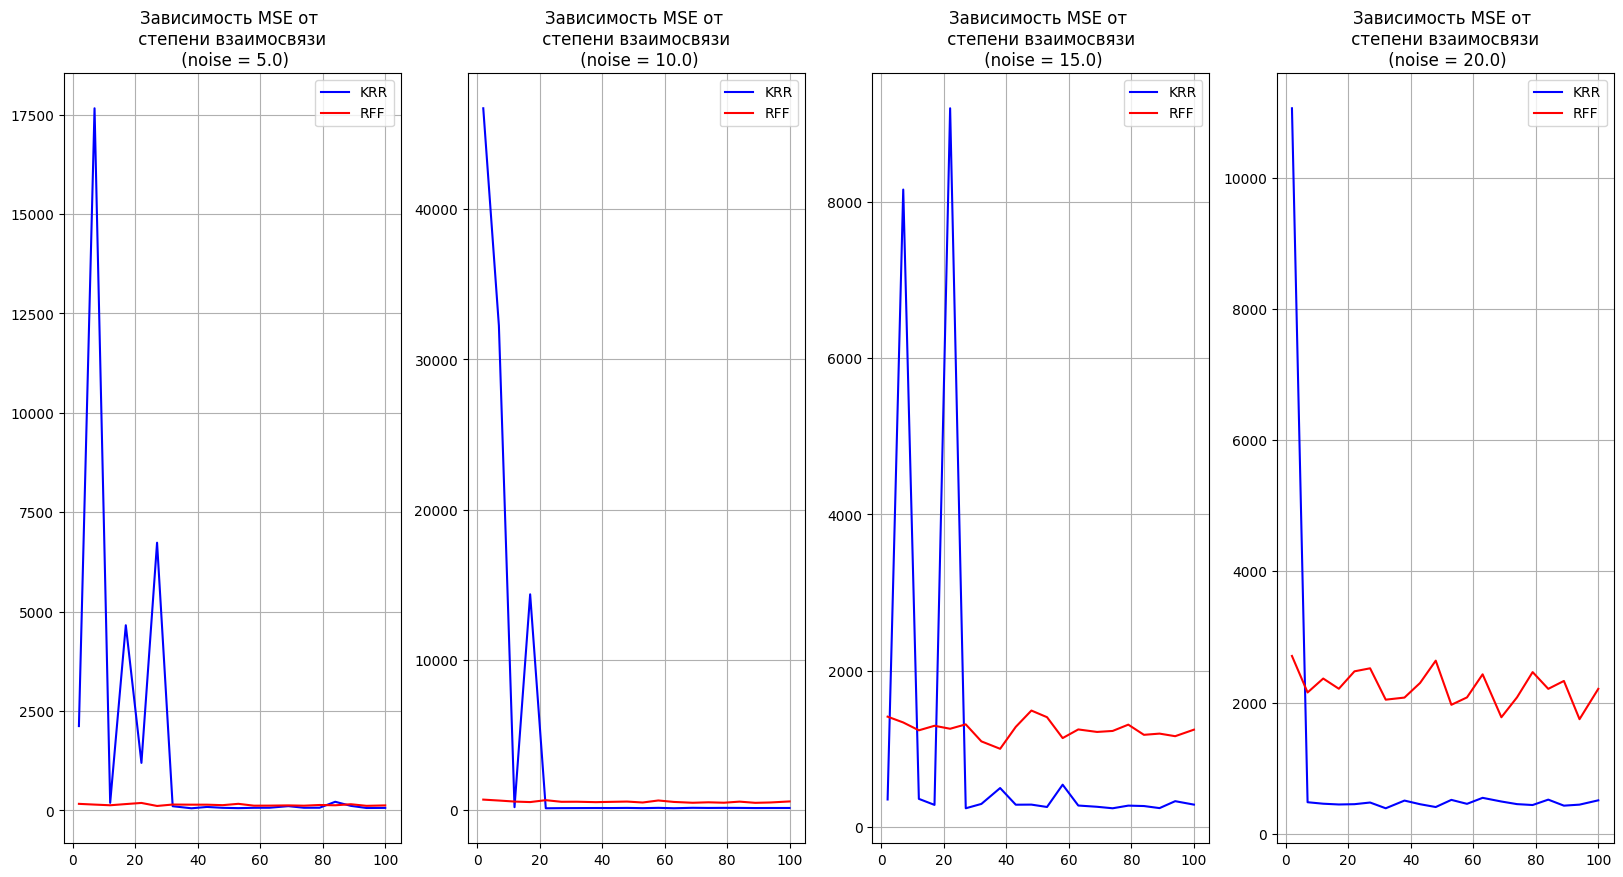

In [107]:
noise = np.linspace(5, 20, 4)

corr = np.linspace(2, 100, 20).astype('int')

f, ax = plt.subplots(1,4,figsize=(20, 10))

for ns in range(len(noise)):

    mse_corr = []

    for i in corr:
        X, y = make_regression(n_samples=1000, n_features=40, random_state=42, bias=1000, effective_rank=i, noise=noise[ns])

        x_tr, x_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.3)

        KRR = KernelRidgeRegression()
        KRR.fit(x_tr, y_tr)

        RFF = RFFPipeline(use_PCA=False,classifier='linreg')
        RFF.fit(x_tr, y_tr)

        m1 = mean_squared_error(y_tst, KRR.predict(x_tst))
        m2 = mean_squared_error(y_tst, RFF.predict(x_tst))

        mse_corr.append([m1, m2])

    mse_corr = np.array(mse_corr)

    ax[ns].set_title(f'Зависимость MSE от \n степени взаимосвязи \n (noise = {noise[ns]})')
    ax[ns].plot(corr, mse_corr[:, 0], color='blue', label='KRR')
    ax[ns].plot(corr, mse_corr[:, 1], color='red', label='RFF')
    ax[ns].legend()
    ax[ns].grid();


> ### <div style='color:red'> Вывод: </div>
>
> #### Эксперименты показали, что использование <code>KRR</code> может быть более полезным на реальных данных (зашумленных и частично коррелированных), чем использование <code>RFF</code>. На графиках видно, что чем больше дисперсия случайного шума в данных и чем больше зависимы признаки, тем лучше качество <code>KRR</code>. На последнем графике тесты проводятся уже на очень зашумленных данных и видно, что корреляция между признаками не влияет на выбор между <code>KRR</code> и <code>RFF</code>